In [25]:
def slope(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return (y2 - y1) / (x2 - x1)

# a x + b = y
# ax + b - y = 0
# ax - y = -b

def line(p1, p2):
    a = slope(p1, p2)
    b = -a * p1[0] + p1[1]
    return (a,b)

def intersection(l1, l2):
    a, c = l1
    b, d = l2
    
    return ((d - c) / (a - b)), ((a*d - b*c)/(a - b))

def above(pt, line):
    return pt[1] > line[0] * pt[0] + line[1]

def below(pt, line):
        return pt[1] < line[0] * pt[0] + line[1]

def upper_bound(pt, gamma):
    return (pt[0], pt[1] + gamma)

def lower_bound(pt, gamma):
    return (pt[0], pt[1] - gamma)

class GreedyPLR:
    def __init__(self, gamma):
        self.__state = "need2"
        self.__gamma = gamma
        
    def process(self, pt):
        self.__last_pt = pt
        if self.__state == "need2":
            self.__s0 = pt
            self.__state = "need1"
        elif self.__state == "need1":
            self.__s1 = pt
            self.__setup()
            self.__state = "ready"
        elif self.__state == "ready":
            return self.__process(pt)
        else:
            assert False
    
    def __setup(self):
        self.__rho_lower = line(upper_bound(self.__s0, self.__gamma),
                                lower_bound(self.__s1, self.__gamma))
        self.__rho_upper = line(lower_bound(self.__s0, self.__gamma),
                                upper_bound(self.__s1, self.__gamma))
        
        self.__sint = intersection(self.__rho_lower, self.__rho_upper)
        
    def __current_segment(self):
        segment_start = self.__s0[0]
        segment_stop = self.__last_pt[0]
        avg_slope = (self.__rho_lower[0] + self.__rho_upper[0]) / 2
        intercept = -avg_slope * self.__sint[0] + self.__sint[1]
        return (segment_start, segment_stop, avg_slope, intercept)
        
    def __process(self, pt):
        if not (above(pt, self.__rho_lower) and below(pt, self.__rho_upper)):
            # we have to start a new segment.
            prev_segment = self.__current_segment()
            
            self.__s0 = pt
            self.__state = "need1"
            
            # return the previous segment
            return prev_segment
        
        # we can tweak our extreme slopes to account for this point.
        # if this point's upper bound is below the current rho_upper,
        # we have to change rho_upper.

        s_upper = upper_bound(pt, self.__gamma)
        s_lower = lower_bound(pt, self.__gamma)
        if below(s_upper, self.__rho_upper):
            self.__rho_upper = line(self.__sint, s_upper)
        
        # if this point's lower bound is above the current rho_lower,
        # we have to change rho_lower
        if above(s_lower, self.__rho_lower):
            self.__rho_lower = line(self.__sint, s_lower)
            
        return None
    
    def finish(self):
        if self.__state == "need2":
            self.__state = "finished"
            return None
        elif self.__state == "need1":
            self.__state = "finished"
            return (self.__s0[0], self.__s0[0] + 1, 0, self.__s0[1])
        elif self.__state == "ready":
            self.__state = "finished"
            return self.__current_segment()
        else:
            assert False
        
def argmax(l):
    return max(enumerate(l), key=lambda x: x[1])[0]

def argmin(l):
    return min(enumerate(l), key=lambda x: x[1])[0]
        

class OptimalPLR:
    def __init__(self, gamma):
        self.__state = "need2"
        self.__gamma = gamma
        
    def process(self, pt):
        self.__last_pt = pt
        if self.__state == "need2":
            self.__s0 = pt
            self.__state = "need1"
        elif self.__state == "need1":
            self.__s1 = pt
            self.__setup()
            self.__state = "ready"
        elif self.__state == "ready":
            return self.__process(pt)
        else:
            assert False
    
    def __setup(self):
        self.__rho_lower = line(upper_bound(self.__s0, self.__gamma),
                                lower_bound(self.__s1, self.__gamma))
        self.__rho_upper = line(lower_bound(self.__s0, self.__gamma),
                                upper_bound(self.__s1, self.__gamma))
        
        self.__upper_hull = [upper_bound(self.__s0, self.__gamma),
                             upper_bound(self.__s1, self.__gamma)]
        self.__lower_hull = [lower_bound(self.__s0, self.__gamma),
                             lower_bound(self.__s1, self.__gamma)]
    def __current_segment(self):
        sint = intersection(self.__rho_lower, self.__rho_upper)
        segment_start = self.__s0[0]
        segment_stop = self.__last_pt[0]
        avg_slope = (self.__rho_lower[0] + self.__rho_upper[0]) / 2
        intercept = -avg_slope * sint[0] + sint[1]
        return (segment_start, segment_stop, avg_slope, intercept)
        
    def __process(self, pt):
        if not (above(pt, self.__rho_lower) and below(pt, self.__rho_upper)):
            # we have to start a new segment.
            prev_segment = self.__current_segment()
            
            self.__s0 = pt
            self.__state = "need1"
            
            # return the previous segment
            return prev_segment
        
        # we can tweak our extreme slopes to account for this point.
        # if this point's upper bound is below the current rho_upper,
        # we have to change rho_upper.

        s_upper = upper_bound(pt, self.__gamma)
        s_lower = lower_bound(pt, self.__gamma)
        if below(s_upper, self.__rho_upper):
            # find the point in the lower hull that would minimize
            # the slope between that point and s_upper. 
            resulting_slopes = [line(x, s_upper)[0] for x in self.__lower_hull]
            idx = argmin(resulting_slopes)
            self.__rho_upper = line(self.__lower_hull[idx], s_upper)
            
            # remove everything from the hull prior to that point, add new point
            self.__lower_hull = self.__lower_hull[idx:]
            self.__lower_hull.append(s_lower)
            self.__lower_hull = update_hull(self.__lower_hull, upper=False)

        
        # if this point's lower bound is above the current rho_lower,
        # we have to change rho_lower
        if above(s_lower, self.__rho_lower):
            # find the point in the upper hull that would maximize
            # the slope between the point and s_lower
            resulting_slopes = [line(x, s_lower)[0] for x in self.__upper_hull]
            idx = argmax(resulting_slopes)
            self.__rho_lower = line(self.__upper_hull[idx], s_lower)
            
            # remove everything from the hull prior to that point, add new point
            self.__upper_hull = self.__upper_hull[idx:]
            self.__upper_hull.append(s_upper)
            self.__upper_hull = update_hull(self.__upper_hull)
        
        return None
    
    def finish(self):
        if self.__state == "need2":
            self.__state = "finished"
            return None
        elif self.__state == "need1":
            self.__state = "finished"
            return (self.__s0[0], self.__s0[0] + 1, 0, self.__s0[1])
        elif self.__state == "ready":
            self.__state = "finished"
            return self.__current_segment()
        else:
            assert False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


             Key Num  Block Num
0    107747800776447          0
1    281893266153982          1
2  27304176570925056          2
3  27414552918647293          3
4  27694930021278464          4
              x_start         slope           y
0     107747800776447  4.887140e-15   -0.404287
1   27304176570925056  4.958190e-15 -133.516000
2   71324640712457984  4.735520e-15 -329.032000
3   99467323685037568  2.898520e-15 -273.184000
4  143272300710355200  4.430580e-15 -616.511000


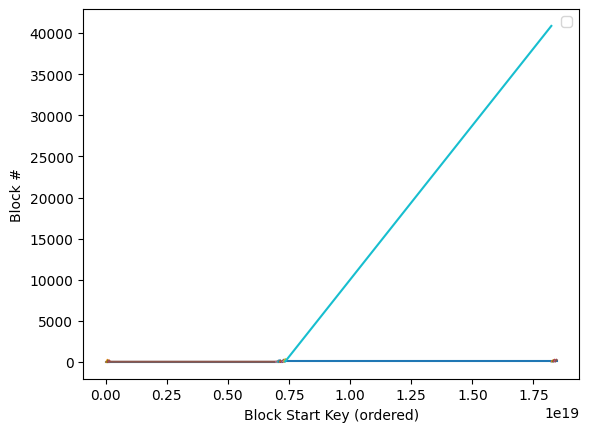

In [26]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def get_y(x,slope,c):
    return slope* x + c
# Read the CSV files
data1 = pd.read_csv("original_data.csv")
data2 = pd.read_csv('plr_data.csv')
print(data1.head())
print(data2.head())


# Plot the data from the two CSV files
plt.step(data1["Key Num"], data1["Block Num"], where="pre")

# Plot the plr lines
for i, r in data2.iloc[1:].iterrows():
    if i != len(data2.iloc[1:]):
        # np.linespace(r[0], next_row[0],10)
        next_row = next(data2.iloc[i+1:].iterrows())[1]
        xl = np.linspace(r[0],next_row[0] ,10)
    else:
        xl = np.linspace(r[0],r[0]+1,10)
    yl = r[1] * xl + r[2]
    plt.plot(xl,yl)

# for row in df:
#     xl = np.linspace()
# Add labels and title
plt.xlabel('Block Start Key (ordered)')
plt.ylabel('Block #')
plt.xlim(72056483302407677,72337288264114531)
# plt.ylim(63,70)
plt.legend()

# Display the plot
plt.show()

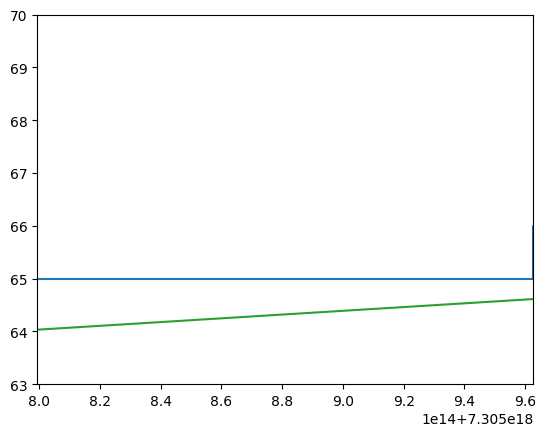

In [27]:
plr = GreedyPLR(0.0005)
lines = []
for i,pt in data1.iloc[1::].iterrows():
    l = plr.process((float(pt[0]), float(pt[1])))
    if l:
        lines.append(l)
    
last = plr.finish()
if last:
    lines.append(last)


len(lines)

plt.step(data1["Key Num"], data1["Block Num"], where="pre")
for l in lines:
    xl = np.linspace(l[0], l[1], 10)
    yl = l[2] * xl + l[3]
    plt.plot(xl,yl)
plt.xlim(7305799467870451712,7305962717408617981)
plt.ylim(63,70)
plt.show()

In [28]:
opt_plr = OptimalPLR(0.005)
line2 = []

for i,pt in data1.iloc[1::].iterrows():
    l = opt_plr.process((float(pt[0]), float(pt[1])))
    if l:
        line2.append(l)
    
last = opt_plr.finish()
if last:
    line2.append(last)


len(lines)

plt.step(data1["Key Num"], data1["Block Num"], where="pre")
for i in range(len(line2)):
    l = line2[i]
    if i == 2:
        continue
    xl = np.linspace(l[0], l[1], 10)
    yl = l[2] * xl + l[3]
    plt.plot(xl,yl)

NameError: name 'update_hull' is not defined